# Multinomial Logistic Regression

The total credits in this document are for: [Machine Learning Mastery: Multinomial Logistic Regression](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/)

## Concept

Multinomial logistic regression is an extension of logistic regression that adds native support for multi-class classification problems. Logistic regression, by default, is limited to two class classification problems. Some extensions like one-vs-rest can allow logistic regression to be used for multi-class classification problems, although they require that the classification problem first be transformed into multiple binary classification problems.  
Instead, the multinomial logistic regression algorithm is an extension to the logistic regression model thah involves changing the loss function to cross-entropy loss an d predict probability distribution to a multinomial probability distribution to natively support multi-class classification problems.

Exercise

First, we will define a synthetic multi-class classification dataset to use as the basis of the investigation. This is a generic dataset that you can easily replace with your own loaded dataset later.

The make_classification() function can be used to generate a dataset with a given number of rows, columns, and classes. In this case, we will generate a dataset with 1,000 rows, 10 input variables or columns, and 3 classes.

In [1]:
from collections import Counter
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
print(X.shape, y.shape)
print(Counter(y))

(1000, 10) (1000,)
Counter({1: 334, 2: 334, 0: 332})


In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [14]:
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# Report the model performance
print('Mean Accuaracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuaracy: 0.681 (0.042)


In this case, we can see that the multinonial logistic regression model with default penalty achieved a mean classification accuaracy of about 68.1% on our synthetic classification dataset

In [15]:
# Fit the model on the whole dataset
model.fit(X, y)

# Define a single row of input data
row = [1.89149379, -0.39847585, 1.63856893, 0.01647165, 1.51892395, -3.52651223, 1.80998823, 0.58810926, -0.02542177, -0.52835426]

# Predict the class label
yhat = model.predict([row])

# Summarize the predicted class
print('Predicted class: %d' % yhat[0])

Predicted class: 1


In this case, we can see that the model predicted the class "1" for the single row of data.  
A benefit of multinomial logistic regression is that it can predict calibrated probabilites across all known class labels in the dataset. This can be achieved by calling the predict_proba() function on the model.

In [16]:
yhat = model.predict_proba([row])

# Summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhat[0])

Predicted Probabilities: [0.16470456 0.50297138 0.33232406]


In this case, we can see that class 1 (e.g. the array index is mapped to the class integer value) has the largest predicted probability with about 0.50.

# Tune Penalty for Multinomial Logisitic Regression

An important hyperparameter to tune for multinomial logistic regression is the penalty term.

This term imposes pressure on the model to seek smaller model weights. This is achieved by adding a weighted sum of the model coefficients to the loss function, encouraging the model to reduce the size of the weights along with the error while fitting the model.

A popular type of penalty is the L2 penalty that adds the (weighted) sum of the squared coefficients to the loss function. A weighting of the coefficients can be used that reduces the strength of the penalty from full penalty to a very slight penalty.

By default, the LogisticRegression class uses the L2 penalty with a weighting of coefficients set to 1.0. The type of penalty can be set via the “penalty” argument with values of “l1“, “l2“, “elasticnet” (e.g. both), although not all solvers support all penalty types. The weighting of the coefficients in the penalty can be set via the “C” argument.

```python
LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.0)
```

- C close to 1.0: Light penalty.
- C close to 0.0: Strong penalty.  

The penalty can be disabled by setting the “penalty” argument to the string “none“.

```python
LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
```

Now that we are familiar with the penalty, let’s look at how we might explore the effect of different penalty values on the performance of the multinomial logistic regression model.

It is common to test penalty values on a log scale in order to quickly discover the scale of penalty that works well for a model. Once found, further tuning at that scale may be beneficial.

We will explore the L2 penalty with weighting values in the range from 0.0001 to 1.0 on a log scale, in addition to no penalty or 0.0.

>0.0000 0.777 (0.037)
>0.0001 0.683 (0.049)
>0.0010 0.762 (0.044)
>0.0100 0.775 (0.040)
>0.1000 0.774 (0.038)
>1.0000 0.777 (0.037)


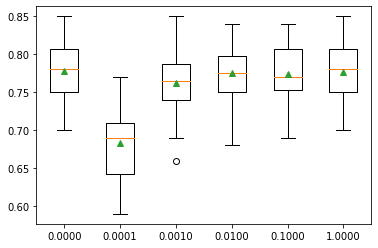

In [17]:
from numpy import mean, std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
    return X, y


def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        key = '%.4f' % p
        if p == 0.0:
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
        else:
            models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
    return models


def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores


X, y = get_dataset()
models = get_models()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In this case, we can see that a C value of 1.0 has the best score of about 77.7%, which is the same using no penalty that achivieves the same score.  

A box and whisker plot is created for the accuracy scores for each configuration and all plots are shown side by side on a figure on the same scale for direct comparison.

In this case, we can see that the larger penalty we use on this dataset (i.e. the smaller the C value), the worse the performance of the model.